In [10]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
import matplotlib.pyplot as plt
import math
import os
import json
import uproot
import mplhep as hep

In [11]:
plt.style.use(hep.style.CMS)

In [2]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)

In [3]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [4]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2
del(xsecs['qcd_300to470'])

In [5]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [6]:
columns=['goodjets.msoftdrop', 'goodjets.pt']

In [7]:
def read_files(input_path):
    if ('.parquet' in os.listdir(input_path)[0]):
        output = ak.from_parquet(f'{input_path}/*', columns=columns)
    else:
        output = {}
        for i in os.listdir(input_path):
            if ('flat400' not in i):
                output[i] = ak.from_parquet(f'{input_path}/{i}/*', columns=columns)
            else:
                continue
    return output

In [8]:
path = '/cms/cephfs/data/store/user/cmoore24/skims/singlemuon/full'

In [9]:
mc = read_files(f'{path}/mc')

In [12]:
mc['ww'] = mc['diboson_ww']
mc['wz'] = mc['diboson_wz']
mc['zz'] = mc['diboson_zz']
del(mc['diboson_ww'])
del(mc['diboson_wz'])
del(mc['diboson_zz'])

In [13]:
for i in mc:
    if type(mc[i]) == dict:
        for j in mc[i]:
            for k in mc[i][j].fields:
                if 'event' in k:
                    continue
                else:
                    try:
                        mc[i][j][k] = ak.firsts(mc[i][j][k])
                    except:
                        continue
    else:
        for j in mc[i].fields:
            if 'event' in j:
                continue
            else:
                try:
                    mc[i][j] = ak.firsts(mc[i][j])
                except:
                    continue

In [14]:
data = read_files(f'{path}/data')

In [15]:
upper = 950
lower = 475

In [16]:
for i in xsecs:
    if type(mc[i]) == dict:
        for j in mc[i]:
            mask = ((mc[i][j].goodjets.pt >= lower) & (mc[i][j].goodjets.pt <= upper))
            mc[i][j] = mc[i][j][mask]
    else:
        mask = ((mc[i].goodjets.pt >= lower) & (mc[i].goodjets.pt <= upper))
        mc[i] = mc[i][mask]

In [17]:
for i in data:
    if type(data[i]) == dict:
        for j in data[i]:
            mask = ((data[i][j].goodjets.pt >= lower) & (data[i][j].goodjets.pt <= upper))
            data[i][j] = data[i][j][mask]
    else:
        mask = ((data[i].goodjets.pt >= lower) & (data[i].goodjets.pt <= upper))
        data[i] = data[i][mask]

In [18]:
data_s = {}
for i in data:
    if "Single" in i:
        data_s[i] = data[i]

In [19]:
data_arr = ak.concatenate([data[i] for i in data_s])

In [55]:
data_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='Data MSD').Weight()
data_hist.fill(msd=data_arr.goodjets.msoftdrop);

In [56]:
def msd_hist(dataset, call):
    make_hist = hist.Hist.new.Reg(40, 40, 200, name='msd', label='MC MSD').Weight()
    make_hist.fill(msd=dataset.goodjets.msoftdrop)
    return make_hist

In [57]:
mc2 = {}
for i in xsecs:
    if type(mc[i]) == dict:
        for j in mc[i]:
            mc2[j] = mc[i][j]
    else:
        mc2[i] = mc[i]
mc = mc2

In [58]:
hists = {}
for i in mc:
    if type(mc[i]) == dict:
        hists[i] = {}
        for j in mc[i]:
            hists[i][j] = msd_hist(mc[i][j])
    else:
        hists[i] = msd_hist(mc[i], j)

In [59]:
IL = 44.99

In [60]:
scaleHgg = ((IL*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
hists['hgg'].view(flow=True)[:] *= scaleHgg

scaleHbb = ((IL*(xsecs['hbb']*1000)*0.581)/(totals['hbb']))
hists['hbb'].view(flow=True)[:] *= scaleHbb

In [61]:
for i in mc:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        scale = ((IL*(xsecs[i]*1000))/(totals[i]))
        hists[i].view(flow=True)[:] *= scale

In [62]:
mc_hist = sum(hists[i] for i in hists)

In [63]:
qcd = sum([hists[i] for i in hists if 'qcd' in i])

In [64]:
wqq = sum([hists[i] for i in hists if 'wqq' in i])

In [65]:
zqq = sum([hists[i] for i in hists if 'zqq' in i])

In [66]:
ttboosted = sum([hists[i] for i in hists if 'ttboosted' in i])

In [67]:
wlnu = sum([hists[i] for i in hists if 'wlnu' in i])

In [85]:
new_hists = {}
new_hists["qcd×1.25"] = qcd * 1.25
new_hists['wqq'] = wqq
new_hists['zqq'] = zqq
new_hists['ttboosted'] = ttboosted
# new_hists['hbb'] = hists['hbb']
# new_hists['hgg'] = hists['hgg']
new_hists['singletop'] = hists['singletop']
new_hists['ww'] = hists['ww']
new_hists['wz'] = hists['wz']
new_hists['zz'] = hists['zz']
# new_hists['tthadronic'] = hists['tthadronic']
new_hists['wlnu'] = wlnu

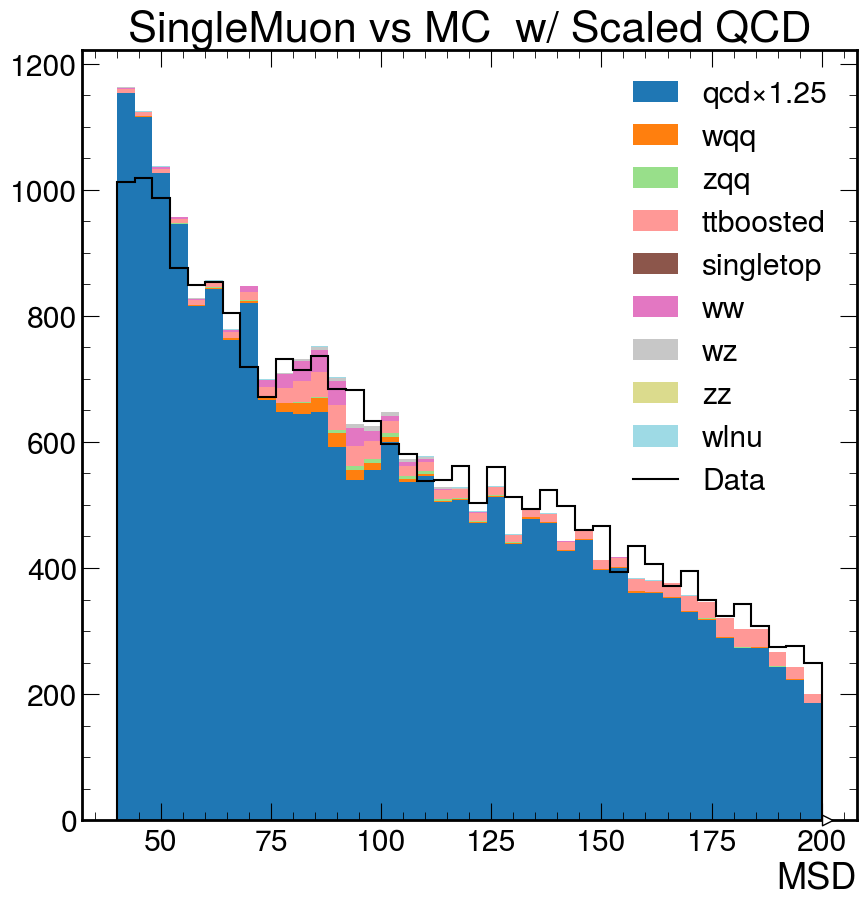

In [86]:
labels = [names for names in new_hists]
color_map = plt.get_cmap('tab20', len(new_hists))
colors = [color_map(i) for i in range(len(new_hists))]
hist.Stack.from_iter([new_hists[i] for i in new_hists]).plot(yerr=False, stack=True, histtype='fill', 
                                                             label=labels, density=False, color=colors)
data_hist.plot1d(label='Data', density=False, yerr=False, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.title('SingleMuon vs MC  w/ Scaled QCD')
plt.xlabel('MSD')
#plt.yscale('log')
plt.show()

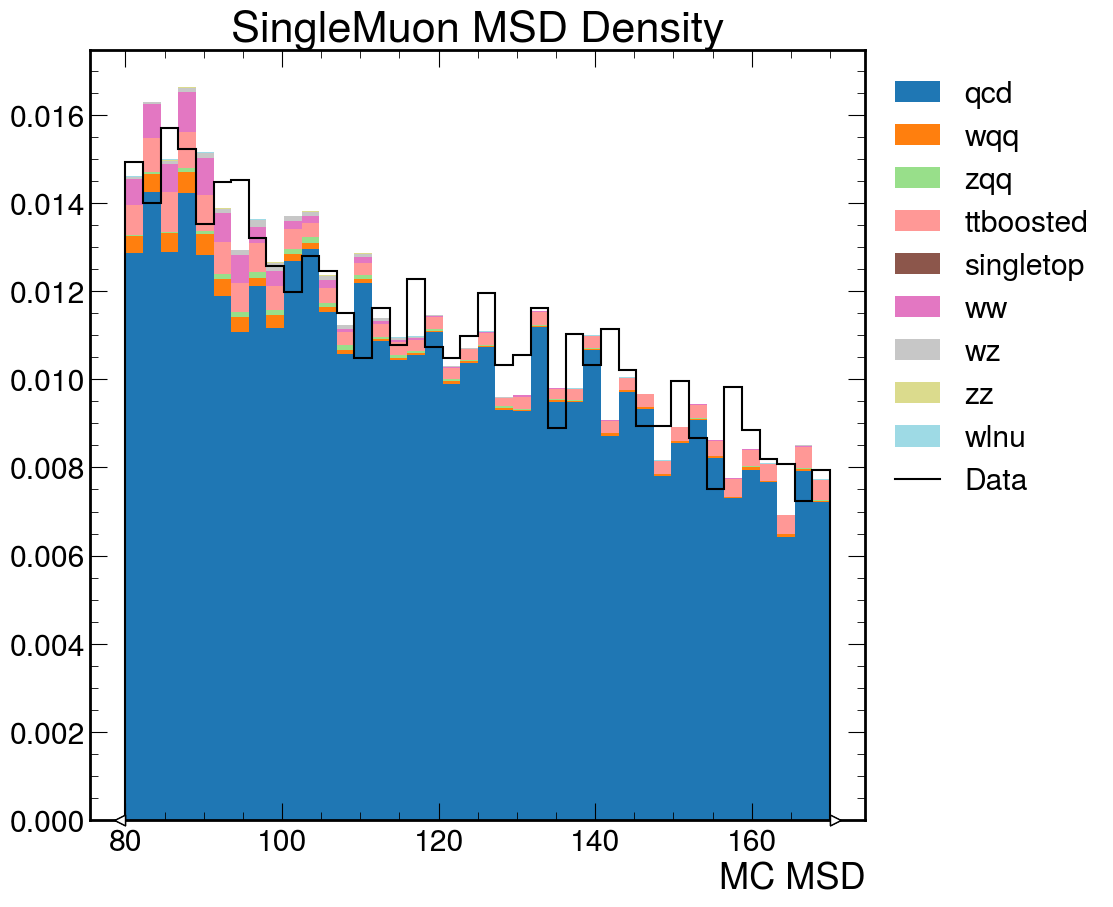

In [54]:
labels = [names for names in new_hists]
color_map = plt.get_cmap('tab20', len(new_hists))
colors = [color_map(i) for i in range(len(new_hists))]
hist.Stack.from_iter([new_hists[i] for i in new_hists]).plot(yerr=False, stack=True, histtype='fill', 
                                                             label=labels, density=True, color=colors)
data_hist.plot1d(label='Data', density=True, yerr=False, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.title('SingleMuon MSD Density')
#plt.yscale('log')
plt.show()

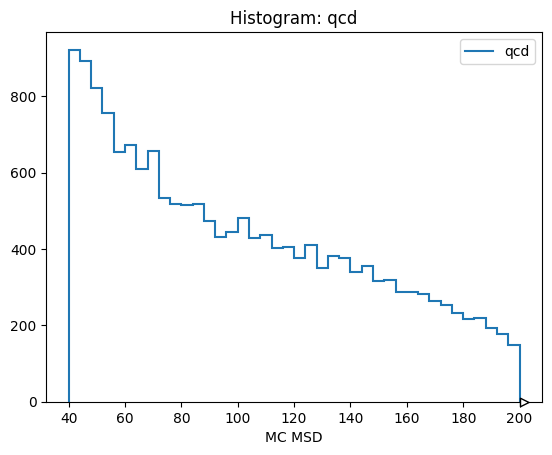

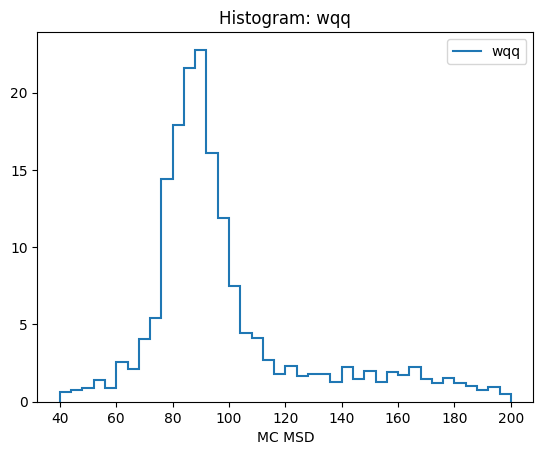

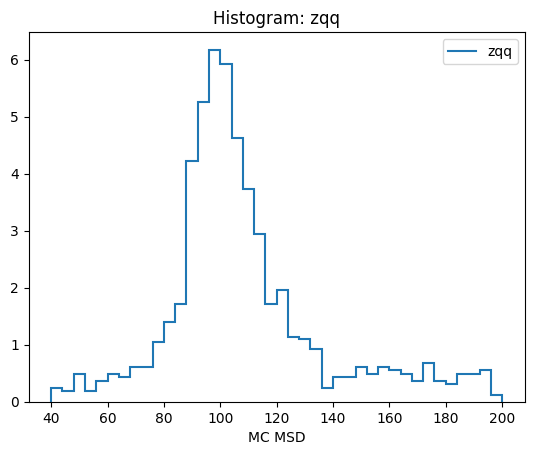

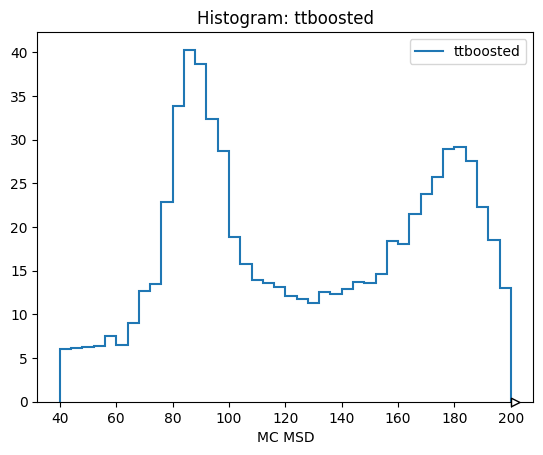

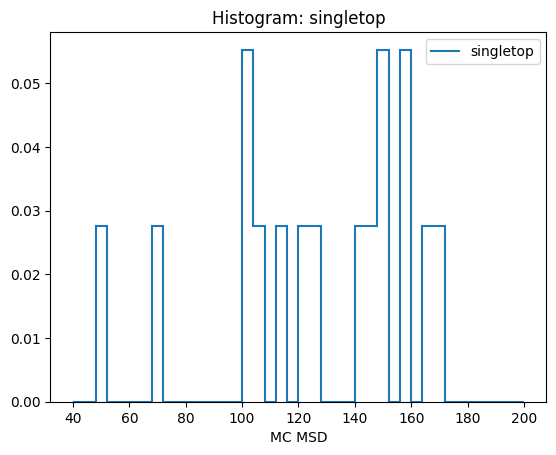

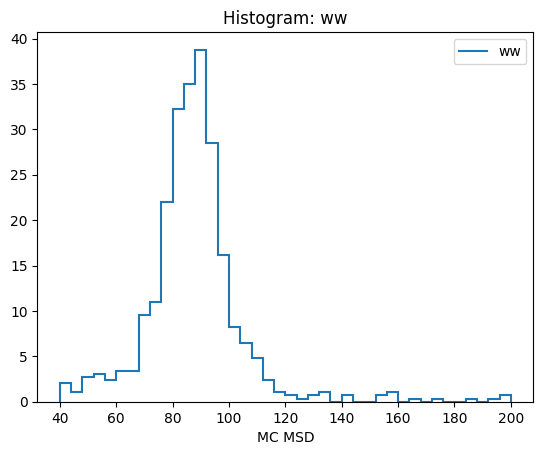

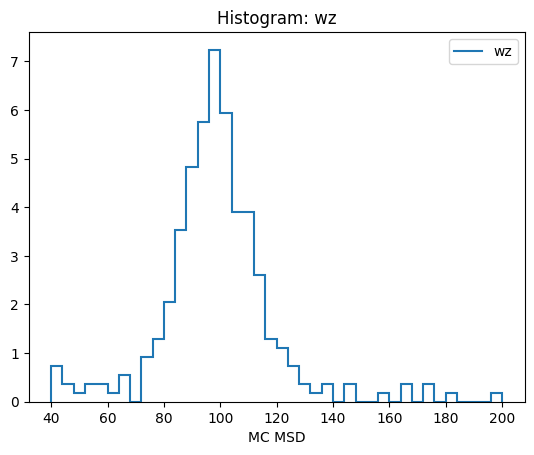

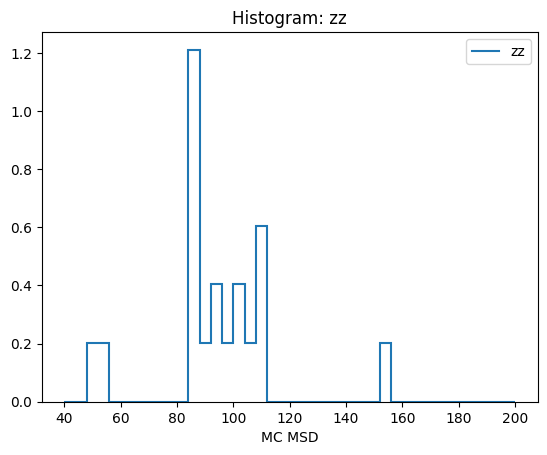

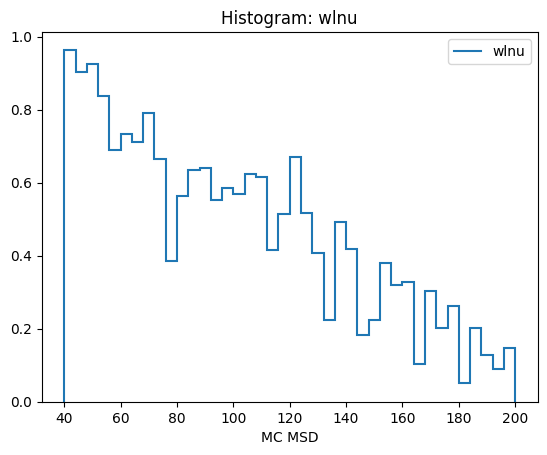

In [42]:
for label, histogram in new_hists.items():
    histogram.plot1d(
        density=False,
        yerr=False,
        histtype='step',
    )
    plt.title(f"Histogram: {label}")
    plt.legend([label])
    plt.show()

In [ ]:
xsecs